In [309]:
import numpy as np
import argparse
import imutils
import math
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]

Center of contour

In [310]:
def countourCenter(image, MIN_THRESH = 1):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(image_gray, (5, 5), 0)
    image_gray = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]
    cnts = cv2.findContours(image_gray.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    coor = [] 
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > MIN_THRESH:
            # compute the center of the contour
            M = cv2.moments(c)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cXfloat = (M["m10"] / M["m00"])
            cYfloat = (M["m01"] / M["m00"])
            coor.append([cXfloat,cYfloat])
            # draw the contour and center of the shape on the image
            cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
            cv2.circle(image, (cX, cY), 7, (255, 255, 255), -1)
            cv2.putText(image, "center", (cX - 20, cY - 20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            
    return image, coor, cnts

Goal: Output X and Y coordinate for each star

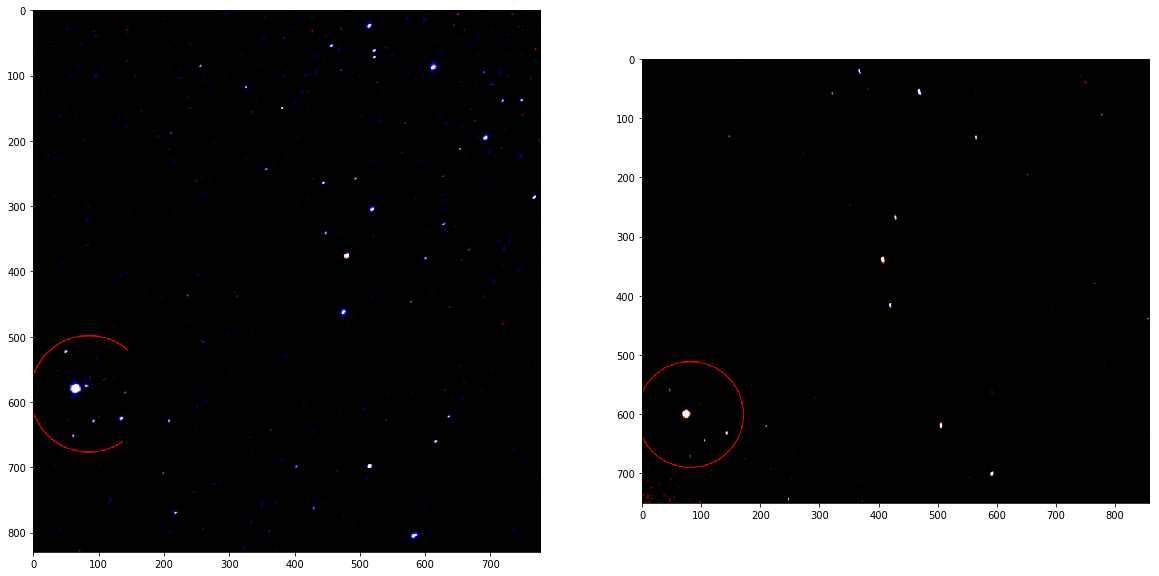

In [311]:
# load the image: 
pic1 = mpimg.imread('/Users/jeffhe/Desktop/commitments/bliss/Solar-sail-localization/picbase/Jupiter Picture1.jpg')
pic2 = mpimg.imread('/Users/jeffhe/Desktop/commitments/bliss/Solar-sail-localization/picbase/Jupiter Picture2.jpg')
plt.subplot(1,2,1), plt.imshow(pic1)
plt.subplot(1,2,2), plt.imshow(pic2)
pic1.setflags(write=1)
pic2.setflags(write=1)

(<matplotlib.axes._subplots.AxesSubplot at 0x16209de48>,
 <matplotlib.image.AxesImage at 0x163a99a20>)

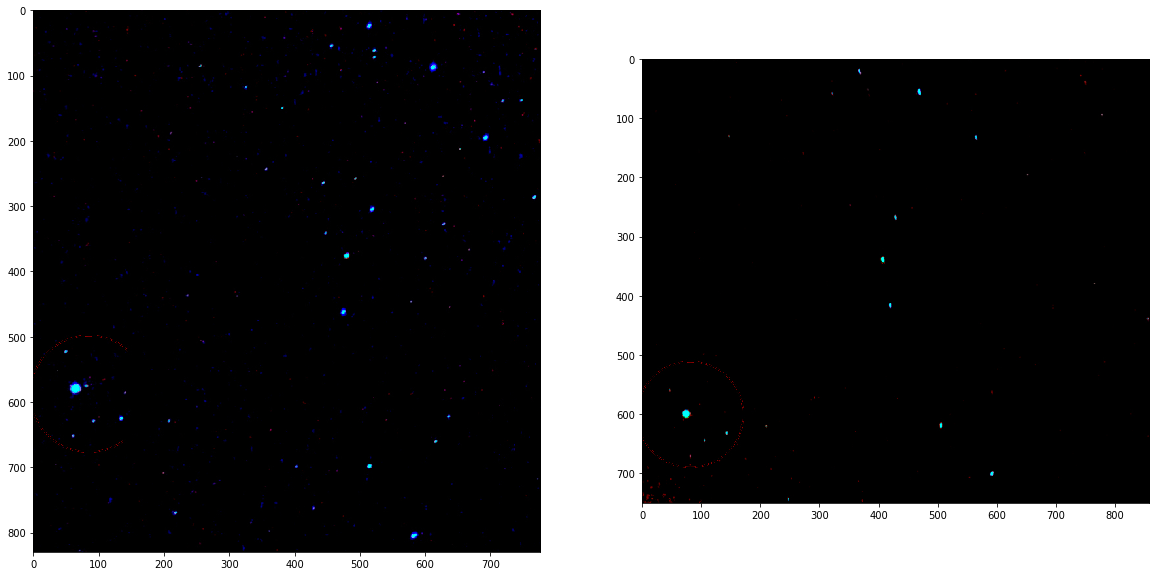

In [312]:
#eliminate the red part in both pictures 
for row in range(len(pic1)): 
    for col in range(len(pic1[row])): 
        if pic1[row,col,0] > 150: 
            pic1[row,col,0] = 0

for row in range(len(pic2)): 
    for col in range(len(pic2[row])): 
        if pic2[row,col,0] > 150: 
            pic2[row,col,0] = 0

plt.subplot(1,2,1), plt.imshow(pic1)
plt.subplot(1,2,2), plt.imshow(pic2)

(<matplotlib.axes._subplots.AxesSubplot at 0x163f47dd8>,
 <matplotlib.image.AxesImage at 0x16423a7b8>)

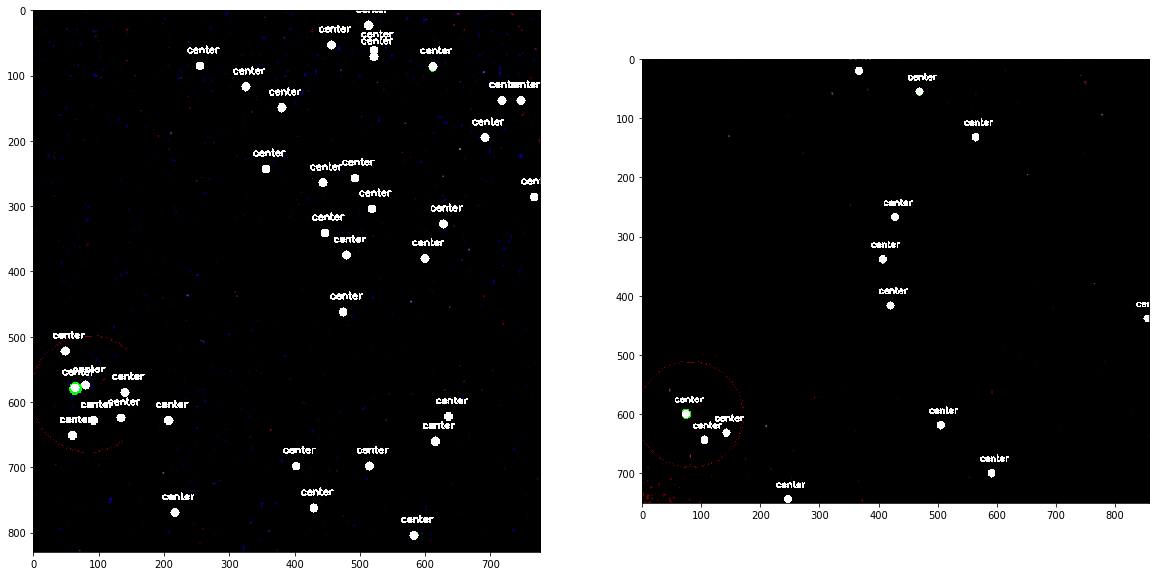

In [313]:
result1, coor1, cnts1 = countourCenter(pic1.copy(),MIN_THRESH = 1)
result2, coor2, cnts2 = countourCenter(pic2.copy(),MIN_THRESH = 1)
plt.subplot(1,2,1), plt.imshow(result1)
plt.subplot(1,2,2), plt.imshow(result2)

classify the stars according to brightness 

(<matplotlib.axes._subplots.AxesSubplot at 0x16470a710>,
 <matplotlib.image.AxesImage at 0x1649e0b00>)

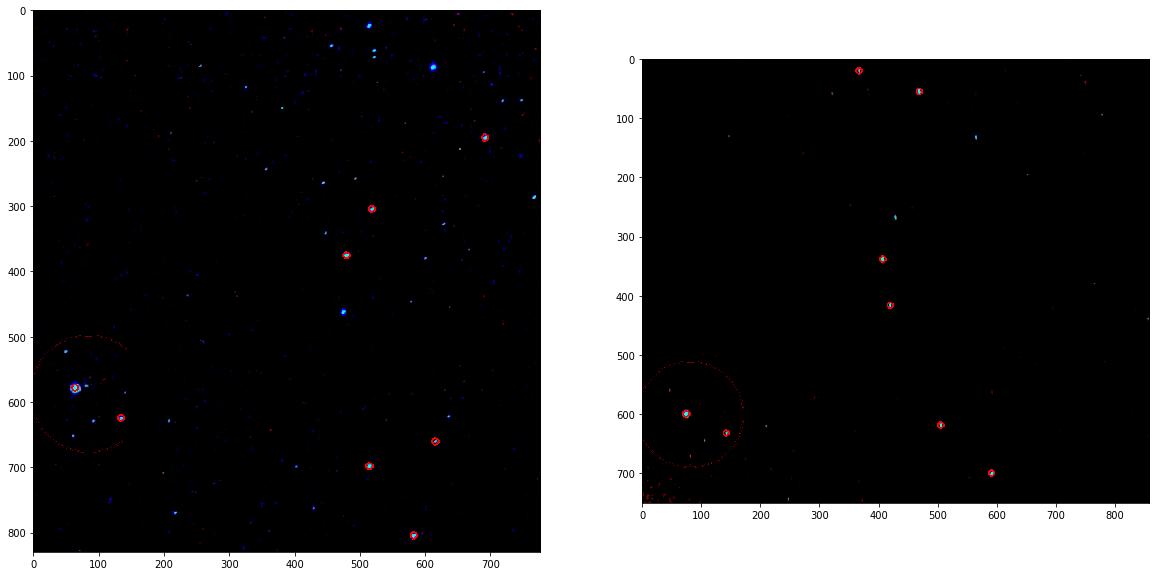

In [314]:
def arrayOfBrightest(image, topN, cnts, coor, MIN_THRESH = 1): 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    means = [] 
    topNArray = [] 
    for contour in cnts:
        if cv2.contourArea(contour) > MIN_THRESH:
            mean, stddev = getContourStat(contour, gray) 
            means.append(mean[0][0]) 
    count = 0 
    while count < topN: 
        index = means.index(max(means))
        topNArray.append(index) 
        means[index] = -1
        count += 1 
    count = 0 
    while count < topN: 
        topNArray[count] = coor[topNArray[count]] 
        count += 1 
    return topNArray
        


def getContourStat(contour,image):
    mask = np.zeros(image.shape,dtype="uint8")
    cv2.drawContours(mask, [contour], -1, 255, -1)
    mean,stddev = cv2.meanStdDev(image,mask=mask) 
    return mean, stddev


def drawCircles(topNArray,img, color):
    img = img.copy() 
    for i in topNArray: 
        cv2.circle(img, (int(i[0]),int(i[1])), 5, color, thickness=2)
    return img

topNArray1 = arrayOfBrightest(pic1.copy(),8,cnts1,coor1)
img_with_circles1 = drawCircles(topNArray1,pic1.copy(),(255,0,0))

topNArray2 = arrayOfBrightest(pic2.copy(),8,cnts2,coor2)  
img_with_circles2 = drawCircles(topNArray2, pic2.copy(),(255,0,0))

plt.subplot(1,2,1), plt.imshow(img_with_circles1)
plt.subplot(1,2,2), plt.imshow(img_with_circles2)


(<matplotlib.axes._subplots.AxesSubplot at 0x164eb3780>,
 <matplotlib.image.AxesImage at 0x165b5ce80>)

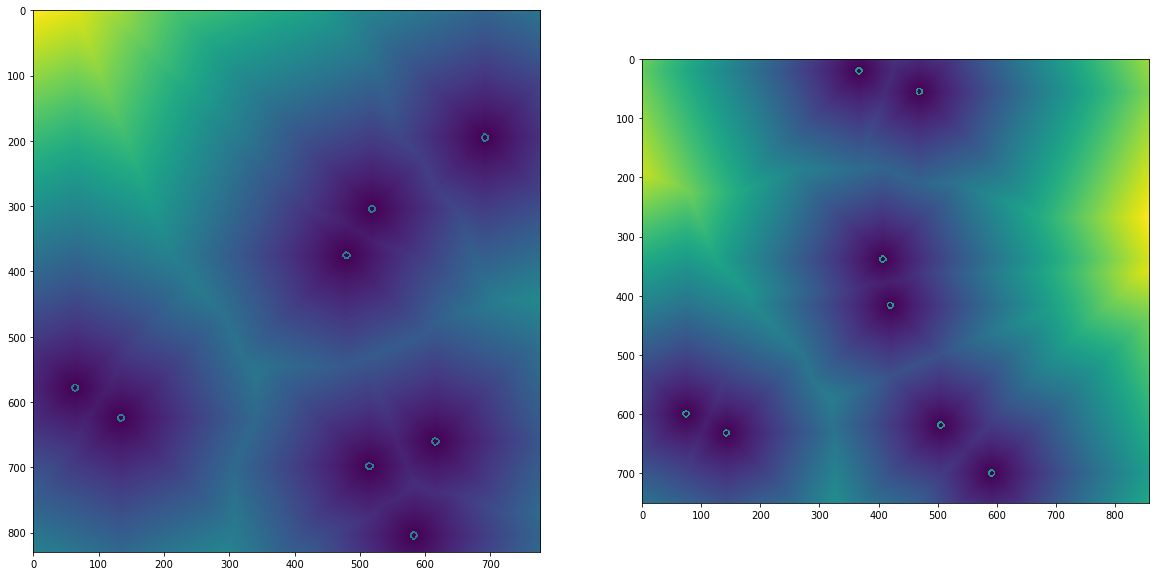

In [315]:

def distanceMap(image,coor): 
    copy = image.copy()
    gray = cv2.cvtColor(copy, cv2.COLOR_BGR2GRAY)
    distanceMap = np.zeros((copy.shape[0],copy.shape[1]), dtype=int)
    for i in coor: 
        distanceMap[int(i[1])][int(i[0])] = 1 
    distanceMap = 1 - distanceMap
    distanceMap = distanceMap.astype(np.uint8)
    distanceMap = cv2.distanceTransform(distanceMap, cv2.DIST_L2, 3)
    display = distanceMap.copy()
    for i in coor: 
        cv2.circle(display, (int(i[0]),int(i[1])), 5, (255,0,0), thickness=2)
    return distanceMap, display

distanceMap1, display1 = distanceMap(pic1,topNArray1)
distanceMap2, display2 = distanceMap(pic2, topNArray2) 
plt.subplot(1,2,1), plt.imshow(display1)
plt.subplot(1,2,2), plt.imshow(display2)

(<matplotlib.axes._subplots.AxesSubplot at 0x165bc9898>,
 <matplotlib.image.AxesImage at 0x165be2cf8>)

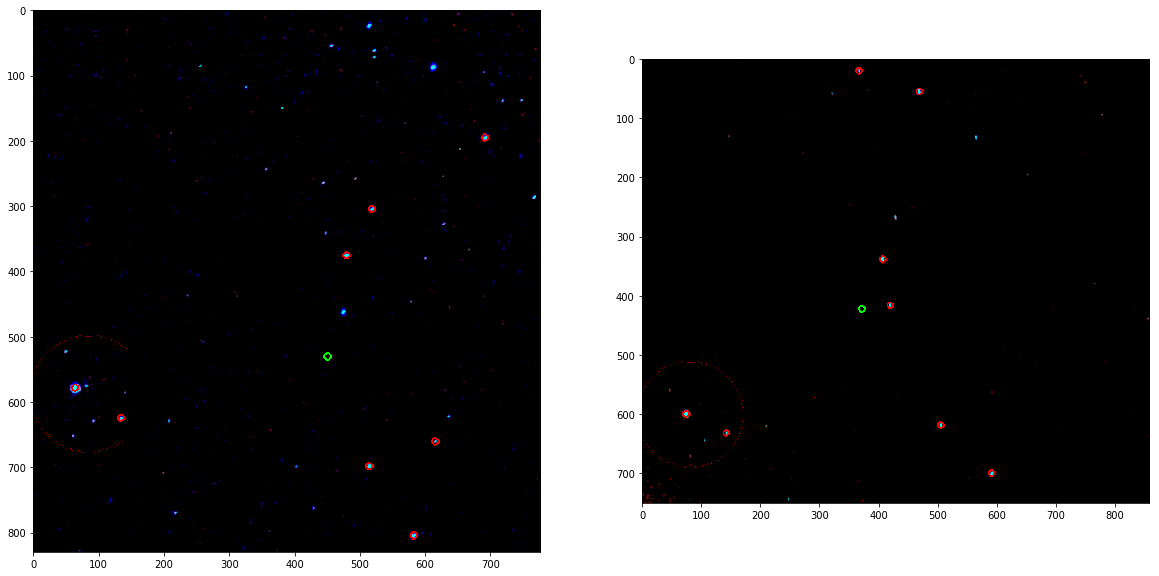

In [316]:
def findCentroid(coor, image): 
    xTotal = 0 
    yTotal = 0 
    for i in coor: 
        xTotal += i[0]
        yTotal += i[1] 
    image = image.copy()
    cv2.circle(image, (int(xTotal / len(coor)),int(yTotal / len(coor))), 5, (0,255,0), thickness=2)
    return [xTotal / len(coor), yTotal / len(coor)] , image

centroid1, centroidImage1 = findCentroid(topNArray1,img_with_circles1)
centroid2, centroidImage2 = findCentroid(topNArray2,img_with_circles2)
plt.subplot(1,2,1), plt.imshow(centroidImage1) 
plt.subplot(1,2,2), plt.imshow(centroidImage2) 

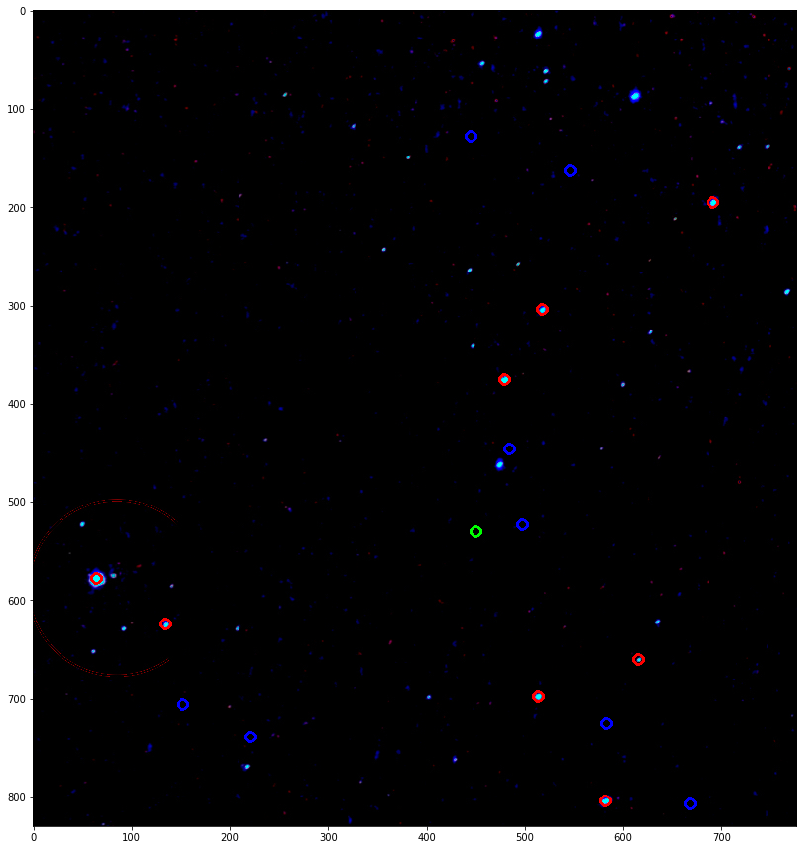

In [317]:
def translation(centroidDatabase, centroidTarget, coor): 
    coor = coor.copy()
    xTrans = centroidTarget[0] - centroidDatabase[0] 
    yTrans = centroidTarget[1] - centroidDatabase[1] 
    for i in coor: 
        i[0] += xTrans 
        i[1] += yTrans 
    return coor 

newCoor = translation(centroid2, centroid1, topNArray2)


newCoorImage = drawCircles(newCoor, centroidImage1, (0,0,255)) 
plt.imshow(newCoorImage) 



In [318]:
def computeDistance(point1, point2): 
    return ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** 0.5

def computeCurrentDotProduct(coor1, coor2, centroid): 
    sum = 0.0
    coor1 = coor1.copy() 
    coor2 = coor2.copy() 
    for i in coor2: 
        vector1 = [i[0] - centroid[0], centroid[1] - i[1]] 
        minDistance = computeDistance(i,coor1[0])
        minPoint = coor1[0]
        for j in coor1: 
            distance = computeDistance(i,j) 
            if (distance < minDistance):
                minDistance = distance 
                minPoint = j 
        vector2 = [minPoint[0] - centroid[0], centroid[1] - minPoint[1]] 
        dotProduct = vector1[0] * vector2[0] + vector1[1] * vector2[1] 
        sum += dotProduct 
        coor1.remove(minPoint) 
    return sum 

def rotateNDegree(coor, centroid, degree): 
    coor = coor.copy() 
    count = 0 
    while count < len(coor): 
        i = coor[count] 
        standardVector = [100,0] 
        vector = [i[0] - centroid[0], centroid[1] - i[1]] 
        theta = math.acos((standardVector[0] * vector[0] + standardVector[1] * vector[1]) / (computeDistance(standardVector,[0,0]) * computeDistance(vector,[0,0])))
        if (vector[1] < 0): 
            theta = -theta 
        theta = theta + math.pi / 180 * degree
        r = computeDistance(i,centroid)
        newVec = [r * math.cos(theta), r * math.sin(theta)] 
        newCoor = [newVec[0] + centroid[0],centroid[1] - newVec[1]]
        coor[count] = newCoor 
        count += 1 
    return coor 
        

In [319]:
def findFit(coor1,coor2, centroid): 
    maxDot = computeCurrentDotProduct(coor1, coor2, centroid) 
    theta = 0 
    i = 0 
    while i < 360: 
        coor2 = rotateNDegree(coor2, centroid,1)
        dot = computeCurrentDotProduct(coor1, coor2, centroid) 
        if (dot > maxDot): 
            maxDot = dot
            theta = i 
        i += 1 
    return theta 

findFit(topNArray1, topNArray2, centroid1)

337

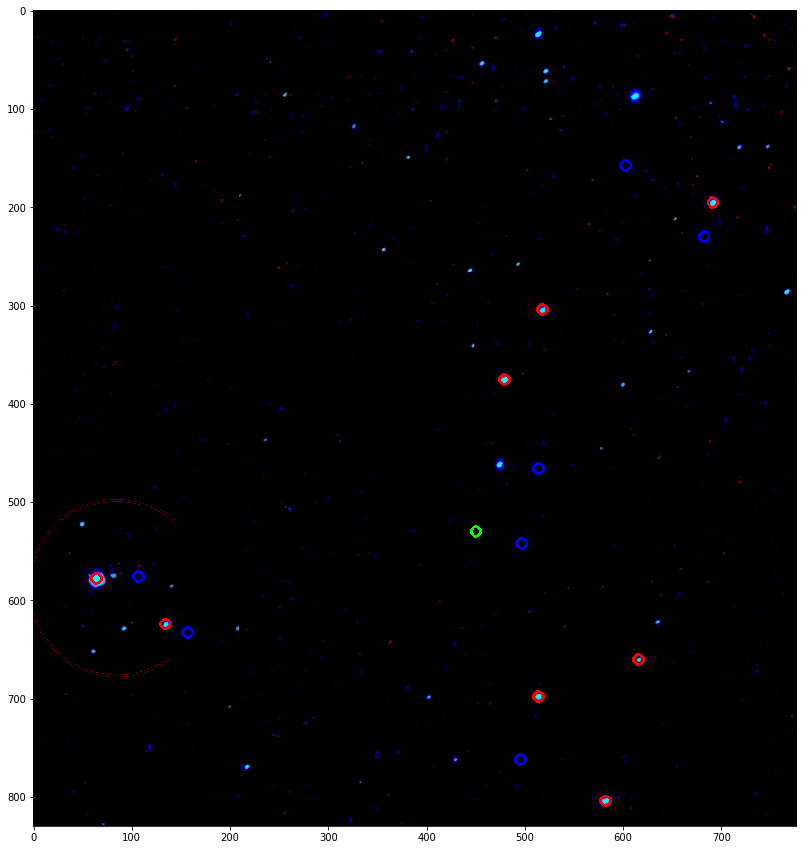

In [321]:
#show that this is correct 
coor = rotateNDegree(topNArray2,centroid1,337) 
l = drawCircles(coor, centroidImage1,(0,0,255))
plt.imshow(l)